In [1]:
from google.colab import files
files.upload()  # Step 2: Upload kaggle.json

!pip install kaggle  # Step 3: Install Kaggle API

!mkdir -p ~/.kaggle  # Step 3: Create .kaggle directory
!mv kaggle.json ~/.kaggle/  # Step 3: Move kaggle.json to .kaggle
!chmod 600 ~/.kaggle/kaggle.json  # Step 3: Set permissions

!kaggle datasets download -d spandan2/cats-faces-64x64-for-generative-models  # Step 4: Download dataset

!unzip cats-faces-64x64-for-generative-models.zip  # Step 5: Unzip dataset

Streaming output truncated to the last 5000 lines.
  inflating: cats/cats/5499.jpg      
  inflating: cats/cats/55.jpg        
  inflating: cats/cats/550.jpg       
  inflating: cats/cats/5500.jpg      
  inflating: cats/cats/5501.jpg      
  inflating: cats/cats/5502.jpg      
  inflating: cats/cats/5503.jpg      
  inflating: cats/cats/5504.jpg      
  inflating: cats/cats/5505.jpg      
  inflating: cats/cats/5506.jpg      
  inflating: cats/cats/5507.jpg      
  inflating: cats/cats/5508.jpg      
  inflating: cats/cats/5509.jpg      
  inflating: cats/cats/551.jpg       
  inflating: cats/cats/5510.jpg      
  inflating: cats/cats/5511.jpg      
  inflating: cats/cats/5512.jpg      
  inflating: cats/cats/5513.jpg      
  inflating: cats/cats/5514.jpg      
  inflating: cats/cats/5515.jpg      
  inflating: cats/cats/5516.jpg      
  inflating: cats/cats/5517.jpg      
  inflating: cats/cats/5518.jpg      
  inflating: cats/cats/5519.jpg      
  inflating: cats/cats/552.jpg       

In [2]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
project_name = 'CAT-dcgan'

In [4]:
# DATA_DIR = '../input/cats-faces-64x64-for-generative-models/'

In [5]:
# print(os.listdir(DATA_DIR))

In [6]:
# print(os.listdir(DATA_DIR+'/cats')[:10])
print(os.listdir('/content/cats')[:10])

['10240.jpg', '13417.jpg', '15516.jpg', '11374.jpg', '6152.jpg', '1074.jpg', '7498.jpg', '6623.jpg', '4313.jpg', '9975.jpg']


In [7]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [8]:
train_ds = ImageFolder('/content/cats', transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [10]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [11]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

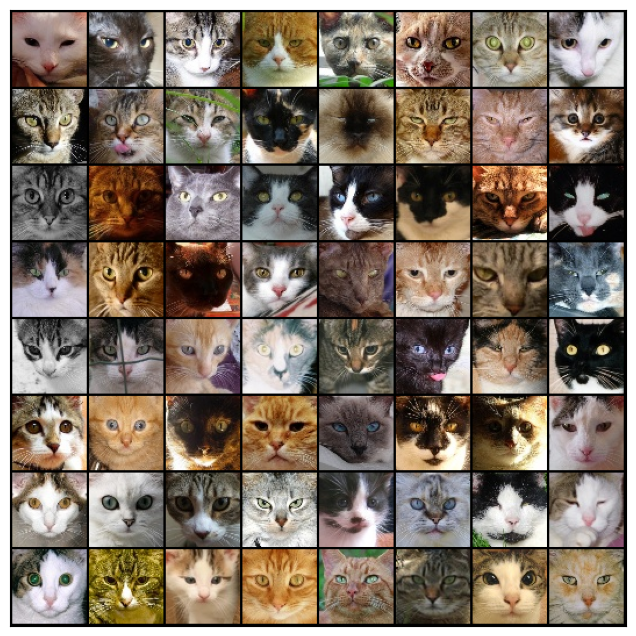

In [12]:
show_batch(train_dl)

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_dl, device)

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [17]:
discriminator = to_device(discriminator, device)

In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


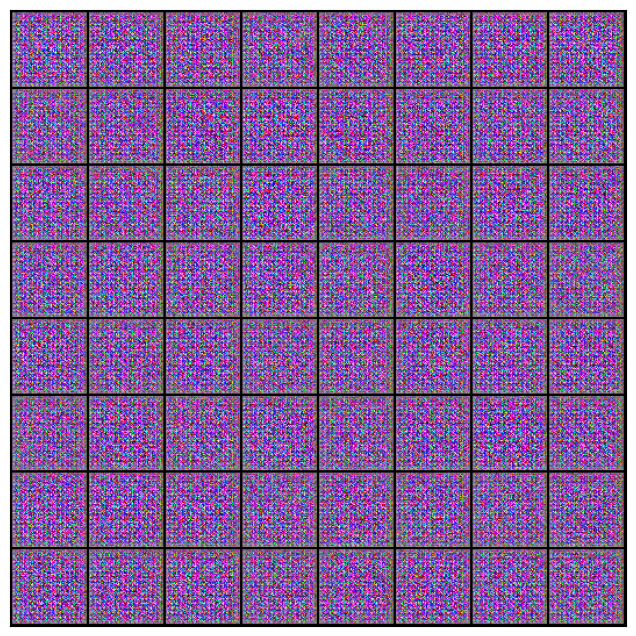

In [20]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [21]:
generator = to_device(generator, device)

In [22]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [23]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [24]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [25]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [26]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [27]:
save_samples(0, fixed_latent)

Saving generated-images-0000.png


In [28]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [29]:
lr = 0.0002
epochs = 60

In [30]:
history = fit(epochs, lr)

  0%|          | 0/124 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/60], loss_g: 4.8287, loss_d: 0.5581, real_score: 0.6144, fake_score: 0.0106
Saving generated-images-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/60], loss_g: 4.0628, loss_d: 0.1383, real_score: 0.9183, fake_score: 0.0492
Saving generated-images-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/60], loss_g: 4.6068, loss_d: 0.3804, real_score: 0.9295, fake_score: 0.2422
Saving generated-images-0003.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/60], loss_g: 1.0825, loss_d: 1.4988, real_score: 0.3071, fake_score: 0.1304
Saving generated-images-0004.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/60], loss_g: 2.9574, loss_d: 0.8557, real_score: 0.6946, fake_score: 0.2927
Saving generated-images-0005.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/60], loss_g: 5.8409, loss_d: 0.5688, real_score: 0.9392, fake_score: 0.3626
Saving generated-images-0006.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/60], loss_g: 2.7822, loss_d: 0.3744, real_score: 0.8450, fake_score: 0.1624
Saving generated-images-0007.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/60], loss_g: 2.8359, loss_d: 0.6002, real_score: 0.8220, fake_score: 0.2835
Saving generated-images-0008.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/60], loss_g: 3.1588, loss_d: 0.6772, real_score: 0.7278, fake_score: 0.2236
Saving generated-images-0009.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/60], loss_g: 4.1236, loss_d: 0.7193, real_score: 0.8227, fake_score: 0.3682
Saving generated-images-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/60], loss_g: 4.2866, loss_d: 0.1606, real_score: 0.9809, fake_score: 0.1283
Saving generated-images-0011.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/60], loss_g: 2.7064, loss_d: 0.5888, real_score: 0.7282, fake_score: 0.2175
Saving generated-images-0012.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/60], loss_g: 2.7947, loss_d: 0.7239, real_score: 0.6306, fake_score: 0.1876
Saving generated-images-0013.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/60], loss_g: 4.8205, loss_d: 0.3142, real_score: 0.9885, fake_score: 0.2429
Saving generated-images-0014.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/60], loss_g: 3.0450, loss_d: 0.1906, real_score: 0.8880, fake_score: 0.0601
Saving generated-images-0015.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/60], loss_g: 2.3324, loss_d: 0.4532, real_score: 0.7563, fake_score: 0.1150
Saving generated-images-0016.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/60], loss_g: 0.0977, loss_d: 2.0592, real_score: 0.1874, fake_score: 0.1997
Saving generated-images-0017.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/60], loss_g: 2.2764, loss_d: 0.5105, real_score: 0.7467, fake_score: 0.0788
Saving generated-images-0018.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/60], loss_g: 4.6615, loss_d: 0.0991, real_score: 0.9358, fake_score: 0.0315
Saving generated-images-0019.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/60], loss_g: 3.4686, loss_d: 0.2573, real_score: 0.8607, fake_score: 0.0941
Saving generated-images-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/60], loss_g: 3.0600, loss_d: 0.3563, real_score: 0.7271, fake_score: 0.0153
Saving generated-images-0021.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/60], loss_g: 5.5662, loss_d: 0.1805, real_score: 0.9677, fake_score: 0.1272
Saving generated-images-0022.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/60], loss_g: 2.2554, loss_d: 0.3838, real_score: 0.7302, fake_score: 0.0523
Saving generated-images-0023.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/60], loss_g: 0.6266, loss_d: 0.6820, real_score: 0.5436, fake_score: 0.0172
Saving generated-images-0024.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/60], loss_g: 3.9237, loss_d: 6.5286, real_score: 0.0038, fake_score: 0.0003
Saving generated-images-0025.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/60], loss_g: 4.0932, loss_d: 0.2062, real_score: 0.8310, fake_score: 0.0184
Saving generated-images-0026.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/60], loss_g: 5.0986, loss_d: 0.0220, real_score: 0.9912, fake_score: 0.0129
Saving generated-images-0027.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/60], loss_g: 4.7344, loss_d: 3.8784, real_score: 0.0257, fake_score: 0.0002
Saving generated-images-0028.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/60], loss_g: 1.2381, loss_d: 2.0333, real_score: 0.1424, fake_score: 0.0036
Saving generated-images-0029.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/60], loss_g: 4.5884, loss_d: 0.4890, real_score: 0.6185, fake_score: 0.0081
Saving generated-images-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/60], loss_g: 7.3298, loss_d: 6.9749, real_score: 0.0012, fake_score: 0.0000
Saving generated-images-0031.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/60], loss_g: 4.6536, loss_d: 0.2371, real_score: 0.9804, fake_score: 0.1762
Saving generated-images-0032.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/60], loss_g: 0.9296, loss_d: 0.6611, real_score: 0.5623, fake_score: 0.0031
Saving generated-images-0033.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/60], loss_g: 12.4311, loss_d: 1.1897, real_score: 0.8733, fake_score: 0.6045
Saving generated-images-0034.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/60], loss_g: 3.6301, loss_d: 0.3075, real_score: 0.7795, fake_score: 0.0259
Saving generated-images-0035.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/60], loss_g: 1.4616, loss_d: 0.8856, real_score: 0.4514, fake_score: 0.0055
Saving generated-images-0036.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/60], loss_g: 5.2567, loss_d: 0.0753, real_score: 0.9739, fake_score: 0.0467
Saving generated-images-0037.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/60], loss_g: 4.5535, loss_d: 0.1350, real_score: 0.9821, fake_score: 0.1055
Saving generated-images-0038.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/60], loss_g: 5.0101, loss_d: 0.1472, real_score: 0.8928, fake_score: 0.0205
Saving generated-images-0039.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/60], loss_g: 7.5903, loss_d: 0.0073, real_score: 0.9932, fake_score: 0.0005
Saving generated-images-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/60], loss_g: 2.2006, loss_d: 1.3605, real_score: 0.3461, fake_score: 0.0006
Saving generated-images-0041.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/60], loss_g: 0.3133, loss_d: 3.5408, real_score: 0.0559, fake_score: 0.0154
Saving generated-images-0042.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/60], loss_g: 5.3808, loss_d: 0.1327, real_score: 0.9735, fake_score: 0.0941
Saving generated-images-0043.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/60], loss_g: 6.2836, loss_d: 0.4567, real_score: 0.9967, fake_score: 0.3247
Saving generated-images-0044.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/60], loss_g: 4.5281, loss_d: 0.0907, real_score: 0.9237, fake_score: 0.0097
Saving generated-images-0045.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/60], loss_g: 3.6537, loss_d: 0.2644, real_score: 0.8777, fake_score: 0.1020
Saving generated-images-0046.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/60], loss_g: 6.4670, loss_d: 0.2865, real_score: 0.7523, fake_score: 0.0002
Saving generated-images-0047.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/60], loss_g: 6.6868, loss_d: 0.0774, real_score: 0.9285, fake_score: 0.0030
Saving generated-images-0048.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/60], loss_g: 4.0705, loss_d: 0.0591, real_score: 0.9847, fake_score: 0.0421
Saving generated-images-0049.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/60], loss_g: 4.0929, loss_d: 0.1289, real_score: 0.9741, fake_score: 0.0893
Saving generated-images-0050.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/60], loss_g: 7.5711, loss_d: 0.0718, real_score: 0.9355, fake_score: 0.0014
Saving generated-images-0051.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/60], loss_g: 4.9997, loss_d: 0.2371, real_score: 0.8212, fake_score: 0.0028
Saving generated-images-0052.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [53/60], loss_g: 5.1495, loss_d: 0.2277, real_score: 0.8094, fake_score: 0.0013
Saving generated-images-0053.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [54/60], loss_g: 5.8531, loss_d: 7.1951, real_score: 0.0009, fake_score: 0.0000
Saving generated-images-0054.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [55/60], loss_g: 4.4850, loss_d: 0.1393, real_score: 0.9452, fake_score: 0.0761
Saving generated-images-0055.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [56/60], loss_g: 3.3084, loss_d: 2.4282, real_score: 0.0952, fake_score: 0.0015
Saving generated-images-0056.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [57/60], loss_g: 0.4502, loss_d: 1.7164, real_score: 0.2723, fake_score: 0.2235
Saving generated-images-0057.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [58/60], loss_g: 5.1676, loss_d: 0.0194, real_score: 0.9912, fake_score: 0.0104
Saving generated-images-0058.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [59/60], loss_g: 5.1157, loss_d: 0.3941, real_score: 0.8922, fake_score: 0.2213
Saving generated-images-0059.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [60/60], loss_g: 8.5885, loss_d: 0.0022, real_score: 0.9984, fake_score: 0.0006
Saving generated-images-0060.png


In [31]:
losses_g, losses_d, real_scores, fake_scores = history

In [32]:
from IPython.display import Image

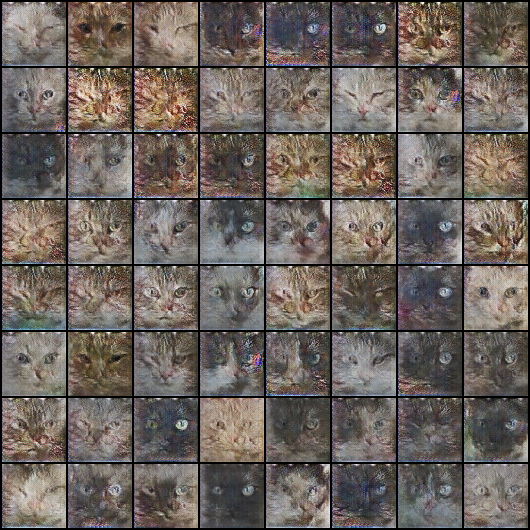

In [33]:
Image('./generated/generated-images-0060.png')

In [34]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

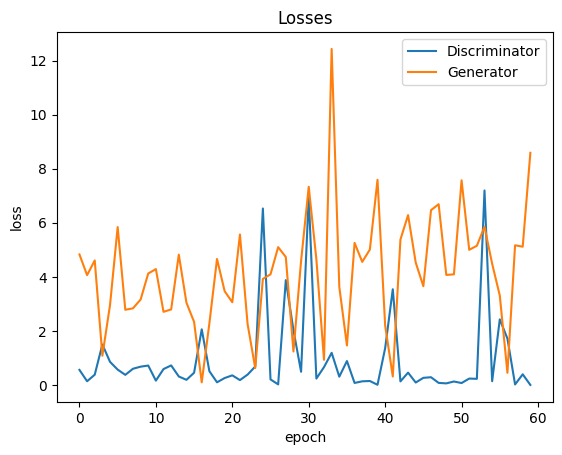

In [35]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

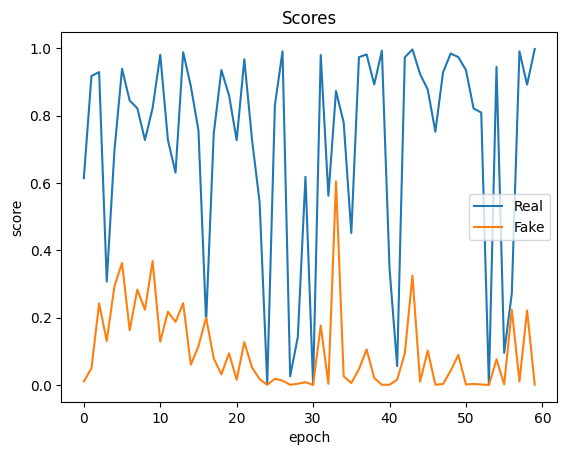

In [36]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');